In [ ]:
%pylab inline
import geopandas as gpd
import pandas as pd
import os
import mplleaflet

in_data_dir = '/Users/datateam/Desktop/SASAP/ADFG/'
out_data_dir = '/Users/datateam/Desktop/SASAP/HabMetricsOut/'

infp = lambda s: os.path.join(in_data_dir, s)
outfp = lambda s: os.path.join(out_data_dir, s)

Populating the interactive namespace from numpy and matplotlib


# Regions

Importing shapefiles for fish passage and regional data.

In [3]:
fish_pass = infp('ADFG_fish_passage.shp')
fp = gpd.read_file(fish_pass)
regs = infp('/Users/datateam/Desktop/SASAP/HUC8_rebuild/output/sasap_regions.shp')
regions = gpd.read_file(regs)

# Culverts

I want to attribute regions with data on the impact of culverts on fish passage. 

I'll subset regions by the following data:
* Number of culverts in each category: black = culvert status unknown, green = likely adquate, grey = possibly inadequate, red = likely indequate, red and grey = uncertainty of adequacy but likely inadequate

Checking out fish passage data.

In [4]:
fp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 31 columns):
OBJECTID      2930 non-null int64
site          2930 non-null object
AWCStreamN    590 non-null object
streamName    2835 non-null object
HUCCode       2820 non-null object
watershedN    225 non-null object
roadName      2907 non-null object
decDegLat     2930 non-null float64
decDegLon     2930 non-null float64
survey        2930 non-null object
projectCod    2930 non-null object
site1         2930 non-null object
surveyDate    2930 non-null float64
surveyTime    2930 non-null float64
failureMec    1966 non-null object
failureM_1    1335 non-null object
failureM_2    829 non-null object
failureM_3    433 non-null object
failureM_4    221 non-null object
failureM_5    88 non-null object
RGGRating     2928 non-null object
tidalInflu    2672 non-null object
stepPools     1758 non-null object
streamStag    1722 non-null object
backWatere    2663 non-null object
avgUSOHWWi    

And checking out the region data. Regions are identified by the `region` attribute, so that'll be our key.

In [5]:
regions.head()

,region_id,region,geometry
0,1,Aleutian Islands,(POLYGON ((-1156665.959195634 420855.093106978...
1,2,Arctic,"POLYGON ((571289.9424044372 2143072.479559347,..."
2,3,Bristol Bay,(POLYGON ((-339688.5870041371 973904.876117813...
3,4,Chignik,(POLYGON ((-114381.9018728056 649966.806579366...
4,5,Copper River,"POLYGON ((561012.0068005103 1148300.750064243,..."


In [ ]:
fp.head(5)

Before running any analysis, I'll make sure both `regions` and `fish passage` data are in the Alaska Albers projection ([epsg:3338](http://spatialreference.org/ref/epsg/3338/)).

In [6]:
fp = fp.to_crs(epsg=3338)
regions = regions.to_crs(epsg=3338)

# Count of Mining Footprints

To count mining footprints for each region, I'll first create an intersection dataframe showing mine polygons as `True` or `False` for intersection with regional geometries.

In [7]:
for reg in regions.region:
    geom = regions.query("region==@reg").geometry.iloc[0]
    fp[reg] = fp.intersects(geom)

Now, I can sum up all of those mine polygons that evaluate as `True` for regional intersection. I'll attribute that count to the `region` DataFrame. 
* I will need to change this by category - actually this may be right but I'm not sure yet, need to better understand the code - look up geopandas functions.

In [15]:
sasap_reg = regions.region.sort_index()
print(sasap_reg)

0         Aleutian Islands
1                   Arctic
2              Bristol Bay
3                  Chignik
4             Copper River
5                   Kodiak
6                 Kotzebue
7                Kuskokwim
8               Cook Inlet
9             Norton Sound
10    Prince William Sound
11               Southeast
12                   Yukon
Name: region, dtype: object


In [21]:
for reg in regions.region:
    n_fishpass = fp[reg].sum()
    regions.loc[regions.region==reg, 'n_fishpass'] = n_fishpass
    print(n_fishpass)

111
32
25
0
205
189
0
0
1062
106
43
725
431


This appears to have created the number of fish passages per regions - although it's possible that it represents something else such as number of culverts, I think it is sites (so culverts)

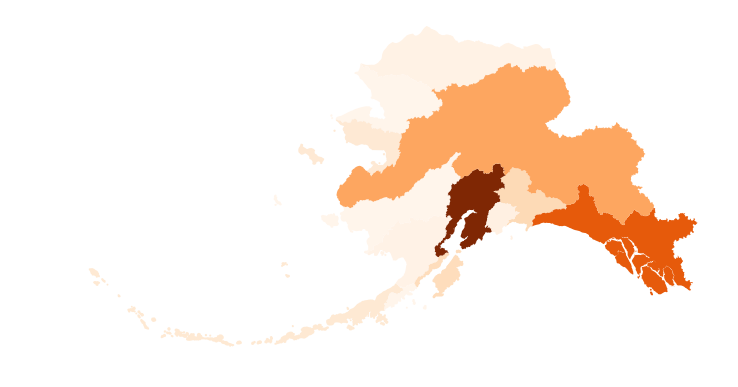

In [22]:
fig, ax = subplots(1,1,figsize=(12,12))
ax = regions.plot(column='n_fishpass', cmap='Oranges', ax=ax, linewidth=0.4)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

In [24]:
regions.sort_values(by='n_fishpass', ascending=False).head(8)
# this is a parameter in sort_values of kind so this might be what you want to look into: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
regions.sort_values(by='n_fishpass', ascending=False, kind=).head(8)




,region_id,region,geometry,n_culverts,n_fishpass
8,9,Cook Inlet,"(POLYGON ((35214.97605528703 1002456.87086566,...",1062.0,1062.0
11,12,Southeast,(POLYGON ((1287776.763303712 744574.0859671872...,725.0,725.0
12,13,Yukon,POLYGON ((-375317.9778843221 1473997.623078777...,431.0,431.0
4,5,Copper River,"POLYGON ((561012.0068005103 1148300.750064242,...",205.0,205.0
5,6,Kodiak,(POLYGON ((115112.5187827438 983292.9990368463...,189.0,189.0
0,1,Aleutian Islands,(POLYGON ((-1156665.959195634 420855.093106979...,111.0,111.0
9,10,Norton Sound,(POLYGON ((-848356.9600070229 1636692.01922057...,106.0,106.0
10,11,Prince William Sound,(POLYGON ((426007.0728565209 1087250.373112139...,43.0,43.0


# Average Area of Mining Footprints

I'll look at the `Shape_Area` attribute of those mining footprints we counted above to find the average area of footprints intersecting each region. Since I'm interested in the characteristics of the mining footprints, I won't clip mining area to regional boundaries.

In [16]:
for reg in regions.region:
    mines_reg = mines[mines[reg]]
    avg_m_area = mines_reg.Shape_Area.mean() * 1e-6
    regions.loc[regions.region==reg, 'avg_m_area'] = avg_m_area

Converting `NaN` values to 0 for those regions without any intersecting mines.

In [17]:
regions['avg_m_area'] = regions['avg_m_area'].fillna(0)

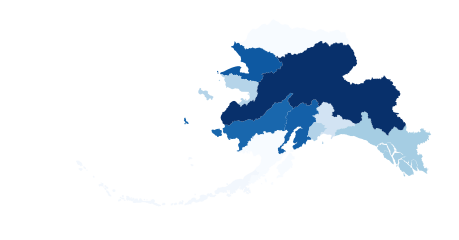

In [18]:
fig, ax = subplots(1,1,figsize=(7,7))
ax = regions.plot(column='avg_m_area', cmap='Blues', ax=ax, linewidth=0.4)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

# Area per Region and Density of Mining Footprints

Now, I'm interested in mining data specific to each region:
* Area of each region covered by mining footprints and 
* Density, defined as ($\frac{mining\,footprint\,area}{regional\,area}$).

For these analyses, I'll have to union mining polygons and clip the resulting shape to regional boundaries. From there, I can evaluate the area of each region covered by mining activity.

In [19]:
for reg in regions.region:
    mines_reg = mines[mines[reg]]
    mines_union = mines_reg.unary_union
    regions_union = regions.query("region==@reg").unary_union
    mines_reg_clip = mines_union.intersection(regions_union)
    regions.loc[regions.region==reg, 'area_mines'] = mines_reg_clip.area * 1e-6

Now, it's one more quick step to find density using the `area_mines` attribute from the previous analysis.

In [20]:
regions['density_mines'] = regions.area_mines/(regions.area * 1e-6)

In [21]:
regions.sort_values(by='density_mines', ascending = False).head()

,region_id,region,geometry,n_mines,avg_m_area,area_mines,density_mines
12,13,Yukon,POLYGON ((-375317.9778843221 1473997.623078777...,391.0,2.212924,864.999527,0.001003
9,10,Norton Sound,(POLYGON ((-848356.9600070229 1636692.01922057...,70.0,0.670258,45.939046,0.000687
8,9,Cook Inlet,"(POLYGON ((35214.97605528703 1002456.87086566,...",24.0,1.804829,51.127322,0.000450
7,8,Kuskokwim,(POLYGON ((-1030125.203115781 1281198.22296843...,26.0,1.743793,45.338615,0.000276
6,7,Kotzebue,(POLYGON ((-678815.2871972915 1819518.97119244...,17.0,1.862390,26.074320,0.000199


Let's map this out. It looks like even though the Yukon region is very large, it also has the highest density of mining impact areas.

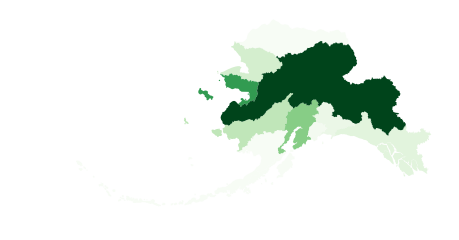

In [22]:
fig, ax = subplots(1,1,figsize=(7,7))
ax = regions.plot(column='density_mines', cmap='Greens', ax=ax, linewidth=0.4)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

Export the results to shapefile and csv formats. I need to drop the "geometry" field in order to export to csv.

In [23]:
regions.to_file(outfp('Regions_with_Mines.shp'))
regions.drop('geometry', axis='columns').to_csv(outfp('Regions_with_Mines.csv'))

# Watersheds

I'm going to run the same analysis as above, but for watersheds. To reiterate, these attributes are:
* Number of mining footprints (mining impact areas) intersecting each watershed.
* Average area of those mining footprints.
* Area (km<sup>2</sup>) impacted by mining within watershed boundaries (area clipped to regional or watershed boundaries).
* Density of mining areas defined as ($\frac{mining\,footprint\,area}{watershed\,area}$).

First, I'll import the watersheds shapefile and convert to the Alaska Albers projection.

In [24]:
watersheds_fp = "/Users/datateam/Desktop/SASAP/HUC8_rebuild/output/sasap_watersheds_gapfix.shp"
watersheds = gpd.read_file(watersheds_fp).to_crs(epsg=3338)

Create the intersection DataFrame.

In [25]:
for wat in watersheds.id_numeric:
    geom = watersheds.query("id_numeric==@wat").geometry.iloc[0]
    mines[wat] = mines.intersects(geom)

Find the number of mining footprints (impact areas) per watershed.

In [26]:
for wat in watersheds.id_numeric:
    n_mines = mines[wat].sum()
    watersheds.loc[watersheds.id_numeric==wat, 'n_mines'] = n_mines

Map the data. I'll decrease the line width on region borders a bit so that we can visualize this better.

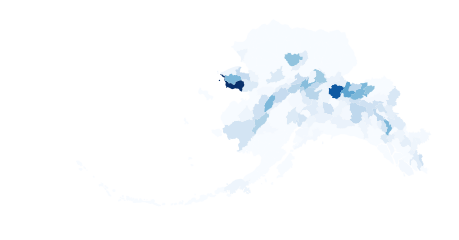

In [27]:
fig, ax = subplots(1,1,figsize=(7,7))
ax = watersheds.plot(column='n_mines', cmap='Blues', ax=ax, linewidth=0.2)
ax.set_axis_off()
foo = ax.axes.set_aspect('equal')

Find the mean area of mining footprints intersecting each watershed.

In [28]:
for wat in watersheds.id_numeric:
    mines_wat = mines[mines[wat]]
    avg_m_area = mines_wat.Shape_Area.mean() * 1e-6
    watersheds.loc[watersheds.id_numeric==wat, 'avg_m_area'] = avg_m_area

In [29]:
watersheds.avg_m_area = watersheds.avg_m_area.fillna(0)

Find the area of mining footprints within watershed boundaires, then find the density = ($\frac{mining\,footprint\,area}{watershed\,area}$).

In [30]:
for wat in watersheds.id_numeric:
    mines_wat = mines[mines[wat]]
    mines_union = mines_wat.unary_union
    watersheds_union = watersheds.query("id_numeric==@wat").unary_union
    mines_reg_clip = mines_union.intersection(watersheds_union)
    watersheds.loc[watersheds.id_numeric==wat, 'area_mines'] = mines_reg_clip.area * 1e-6

In [31]:
watersheds['density_mines'] = watersheds.area_mines/(watersheds.area * 1e-6)

Finally, I'll export the results to shapefile and csv formats.

In [32]:
watersheds.to_file(outfp('Watersheds_with_Mines.shp'))
watersheds.drop('geometry', axis='columns').to_csv(outfp('Watersheds_with_Mines.csv'))